In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Import libs & set global vars
%run '/content/gdrive/My Drive/Colab Notebooks/ImportLibs.ipynb'

#folder on Google Drive:
gdfolder='/content/gdrive/My Drive/DownloadedStockData_MyList/' #'/content/gdrive/My Drive/DownloadedStockData/'
#yrs of history to download fundamentals
yrs=20
pricedatemin='2000-01-01'
pricedatemax='2020-12-18'
#set apikey once:

source={'site' : 'https://financialmodelingprep.com/api/v3/', 'apikey' : 'f02628de5ce2be84c9b758c979ded870'}
## https://financialmodelingprep.com/developer/docs/dashboard
#source={'site' : 'https://fmpcloud.io/api/v3/', 'apikey' : '678054f957cd7cd14c361b5610e2d24e'}
## https://fmpcloud.io/dashboard

Libraries uploaded


In [ ]:
#Stock class definition
%run '/content/gdrive/My Drive/Colab Notebooks/Stock_class_definition.ipynb'

In [ ]:
#Getting list of SP500 companies:
url='https://pkgstore.datahub.io/core/s-and-p-500-companies-financials/constituents-financials_json/data/ddf1c04b0ad45e44f976c1f32774ed9a/constituents-financials_json.json'
data = urllib.request.urlopen(url, context=ctx).read()
info = json.loads(data)
sp500companies=pd.DataFrame(info)
sp500companies.set_index('Symbol', inplace=True)
sp500companies=sp500companies.sort_values(by = 'Market Cap', ascending=False)
#!!!!!!!!!!!!!!!!!!!!!!!!!!!
#Selecting first X companies:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!
sp500companies=sp500companies[412:500]
sp500companies = sp500companies.index.tolist()

companies_to_remove= ['UTX', 'DWDP', 'BRK.B', 'PCLN', 'GGP']
sp500companies=list(set(sp500companies).difference(companies_to_remove))
#removing companies from a list

#adding companies which are not in SP500
stocknames = sp500companies 

#stocknames= ['TSLA'] #['PFE', 'PM', 'LMT', 'KR','TSN','GIS','DG','WMT','PG','ANTM','BIIB','CVS','HCA','HUM','AMGN','UNH','MRK','REGN','INTC','HPQ','IBM','CSCO','AMAT','LRCX','VMC','APD','DHI','BBY','LOW','ORLY','HD','PCAR','EMR','EQR','MET','REGI','XOM','OMC','VZ?','CMCSA','EA','ATVI']
#stocknames=list(set(stocknames))
#stocknames= ['ABBV', 'BABA', 'BIIB', 'CCL', 'CIEN', 'CSCO', 'DHI', 'HUM', 'IBM', 'INTC', 'JPM', 'MRK', 'MSFT', 'PM', 'RDS-A', 'REGI', 'V', 'VRTX', 'VZ', 'XOM', 'NEM', 'DG', 'LMT', 'HII', 'NEE', 'HD', 'CLX', 'PG', 'TSN']
stocknames= ['BMY']
#stocknames=list(set(stocknames))

len(stocknames)

1

In [ ]:
#Using dictionary to create dynamic variables
stocks={}
n_api_requests=0
for stockname in stocknames:
  stocks[stockname] = stock_class(stockname);
  n_api_requests = n_api_requests+stocks[stockname].n_api
  print(stockname + ' processed. Total number of API requests: ', n_api_requests)

BMY processed. Total number of API requests:  0


In [ ]:
#Getting benchmarks data
benchmarknames=['SPY']
benchmarks={}
n_api_requests=0
for benchmarkname in benchmarknames:
  benchmarks[benchmarkname] = stock_class(benchmarkname, benchmark = True) ;
  n_api_requests = n_api_requests+benchmarks[benchmarkname].n_api
  print('Number of requests to API: ', n_api_requests)

Number of requests to API:  0


In [ ]:
screener=pd.DataFrame()
for stockname in stocknames:
  screener=pd.concat([screener, stocks[stockname].fundamentals.iloc[-1:]], axis =0, join='outer')

screener.reset_index(drop=True, inplace=True)
screener.drop(screener.columns.difference(['symbol',
                                            'marketCap',
                                            'grossProfitMargin',
                                            'operatingProfitMargin',
                                            'netProfitMargin',
                                            'effectiveTaxRate',
                                            'priceEarningsRatio',
                                            'earningsYield',
                                            'freeCashFlowYield',
                                            'returnOnEquity',
                                            'roic',
                                            'netDebtToEBITDA',
                                            'longTermDebtToCapitalization',
                                            'interestCoverage',                                          
                                            'currentRatio',
                                            'payoutRatio',   
                                            'dividendYield'
                                             ]), 1, inplace=True)#drop all except
screener.set_index(['symbol'],inplace=True)

#Adding derrived params
for stockname in stocknames:
  try: 
    screener.loc[ stockname , 'Sector' ] = stocks[stockname].profile.loc[0, 'Sector']
  except:
    screener.loc[ stockname , 'Sector' ] = ''
  screener.loc[ stockname , 'Industry' ] = stocks[stockname].profile.loc[0, 'Industry']
  screener.loc[ stockname , 'NumEmployees' ] = stocks[stockname].profile.loc[0, 'NumEmployees']
  screener.loc[ stockname , 'InstitutionalHolders' ] = stocks[stockname].profile.loc[0, 'InstitutionalHolders']
  screener.loc[ stockname , 'InsideHolders' ] = stocks[stockname].profile.loc[0, 'InsideHolders']
  screener.loc[ stockname , 'grossProfitMarginAv3yr' ] = stocks[stockname].average('grossProfitMargin', 3)
  screener.loc[ stockname , 'operatingProfitMarginAv3yr' ] = stocks[stockname].average('operatingProfitMargin', 3)
  screener.loc[ stockname , 'netProfitMarginAv3yr' ] = stocks[stockname].average('netProfitMargin', 3)
  screener.loc[ stockname , 'netDebtToEBITDAAv3yr' ] = stocks[stockname].average('netDebtToEBITDA', 3)
  try: 
    screener.loc[ stockname , 'interest/EBIT' ] = 1/screener.loc[ stockname , 'interestCoverage' ]
  except:
    screener.loc[ stockname , 'interest/EBIT' ] = ''
  screener.loc[ stockname , 'RevenueGrowth1yr' ] = stocks[stockname].growth('revenuePerShare', 1)
  screener.loc[ stockname , 'RevenueGrowth3yr' ] = stocks[stockname].growth('revenuePerShare', 3)
  screener.loc[ stockname , 'epsGrowth1yr' ] = stocks[stockname].growth('netIncomePerShare', 1)
  screener.loc[ stockname , 'epsGrowth3yr' ] = stocks[stockname].growth('netIncomePerShare', 3)
  screener.loc[ stockname , 'CAGRprice' ] = stocks[stockname].cagr_price('2015-01-01','2020-10-01')
  screener.loc[ stockname , 'CAGRwithDivs' ] = stocks[stockname].cagr_price_div('2015-01-01','2020-10-01')
  print(stockname + ' done')

#Removing what not loaded properly
screener=screener[screener['priceEarningsRatio'].notna()]

#giving a proper order pof columns ordet
cols_ordered=[
      'marketCap',
      'Sector',
      'Industry',

      'earningsYield',
      'freeCashFlowYield',

      'RevenueGrowth3yr',            
      'RevenueGrowth1yr',
      'epsGrowth3yr',  
      'epsGrowth1yr',   

      'grossProfitMargin',
      'grossProfitMarginAv3yr',
      'operatingProfitMargin',
      'operatingProfitMarginAv3yr',
      'netProfitMargin',
      'netProfitMarginAv3yr',
      'returnOnEquity',
      'roic',

      'interest/EBIT',                                          
      'currentRatio',   
      'netDebtToEBITDA',
      'netDebtToEBITDAAv3yr',
      'longTermDebtToCapitalization',
      'interestCoverage',

      'payoutRatio',
      'dividendYield',
      'CAGRprice',   
      'CAGRwithDivs',
      
      'NumEmployees',
      'InstitutionalHolders',
      'InsideHolders',

      'effectiveTaxRate',
      ]

screener = screener[cols_ordered]
screener['InsideHolders']=screener['InsideHolders'].str.replace('%','')
screener['InsideHolders']=pd.to_numeric(screener['InsideHolders'], errors='coerce')
screener['InstitutionalHolders']=screener['InstitutionalHolders'].str.replace('%','')
screener['InstitutionalHolders']=pd.to_numeric(screener['InstitutionalHolders'], errors='coerce')
screener['NumEmployees']=screener['NumEmployees'].str.replace(',','')
screener['NumEmployees']=pd.to_numeric(screener['NumEmployees'], errors='coerce')

#Saving screener
screener.to_csv('screener.csv')
shutil.copy('screener.csv',gdfolder + 'screener.csv')

BMY done


'/content/gdrive/My Drive/DownloadedStockData_MyList/screener.csv'

BMY


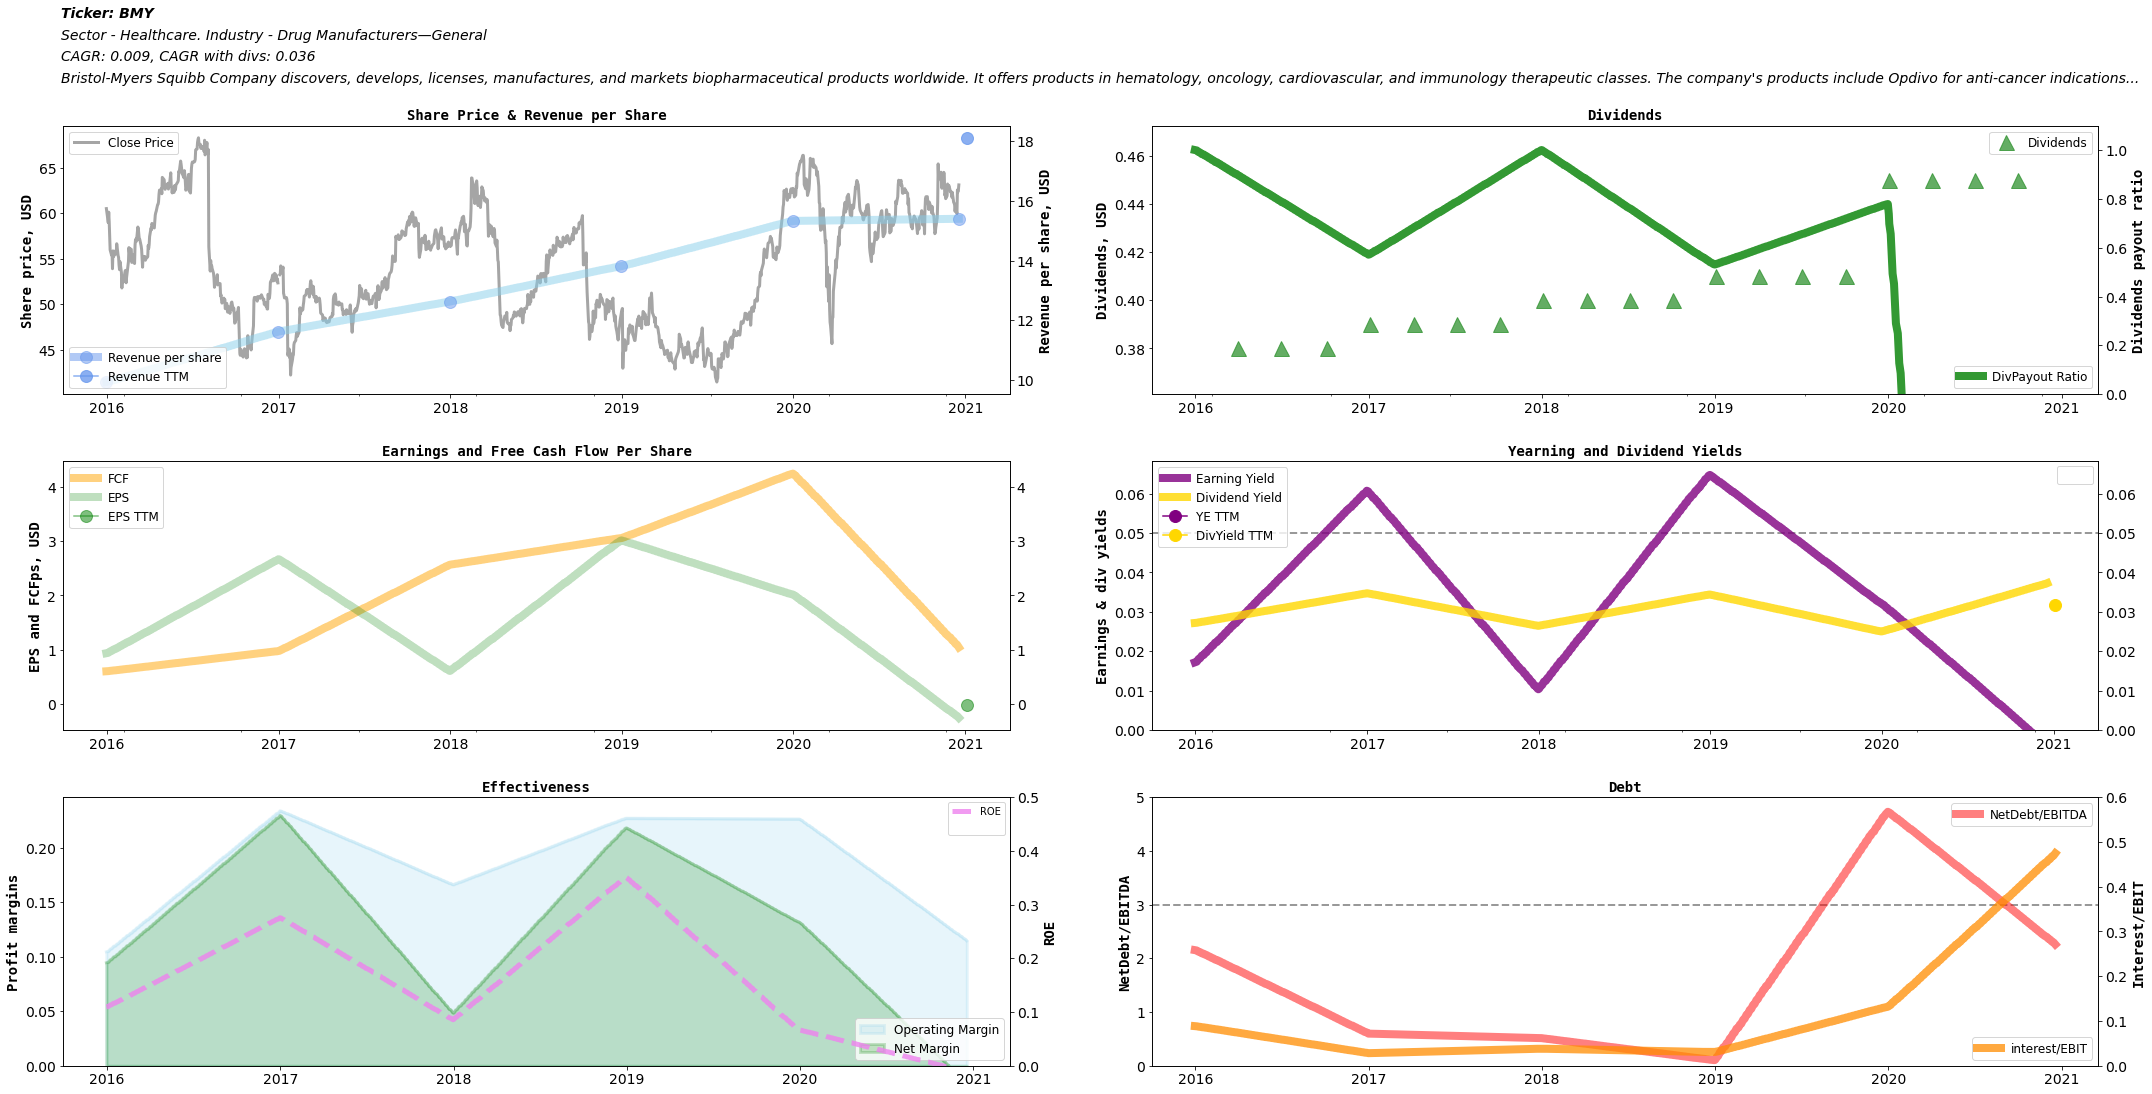

In [ ]:
%run '/content/gdrive/My Drive/Colab Notebooks/Visualize_individual_stock.ipynb'

#Add folder name
n=100
for stockname in stocknames:
  print(stockname)
  vis_stock(stockname, print_to_folder='MyPortfolioPDFs/', name_prefix=str(n))
  n=n+1